In [1]:
!git clone https://github.com/januar-png/earlystop.git

Cloning into 'earlystop'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 41 (delta 19), reused 17 (delta 7), pack-reused 0
Receiving objects: 100% (41/41), 23.28 KiB | 2.33 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [2]:
from earlystop import Earlystop

In [3]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [5]:
batch_size = 32
img_size = 224

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.7, 1)),
    transforms.RandomHorizontalFlip(),  
    transforms.RandomVerticalFlip(),    
    transforms.RandomRotation(7),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(230)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder('/kaggle/input/rice-leafs-disease-dataset/RiceLeafsDisease/train', transform = train_transform)
trainloader = DataLoader(train_set, batch_size, shuffle = True)

test_set = datasets.ImageFolder('/kaggle/input/rice-leafs-disease-dataset/RiceLeafsDisease/validation', transform = test_transform)
testloader = DataLoader(test_set, batch_size, shuffle = False)

In [ ]:
1600/64

In [ ]:
print(len(train_set)/64,len(test_set)/120)

In [6]:
def ConvBlock(in_channels, out_channels, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels),
        nn.BatchNorm2d(in_channels),
        nn.ReLU(inplace = True),
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace = True),
    )

In [7]:
class CNNpenyakitPadi(nn.Module):
    def __init__(self, output_size):
        super(CNNpenyakitPadi, self).__init__()
        self.feature = nn.Sequential(

            ConvBlock(3, 32),
            nn.MaxPool2d(2,2),
            
            ConvBlock(32, 64),
            nn.MaxPool2d(2,2),
            
            ConvBlock(64, 128),
            nn.MaxPool2d(2,2),
            
            ConvBlock(128, 128),
            nn.MaxPool2d(2,2),
            
            ConvBlock(128, 512)
        
        )
        self.flatten = nn.Flatten()
        self.avgpool = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Linear(512,output_size),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.feature(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [8]:
from tqdm import tqdm

In [9]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

In [16]:
def fit(train_set, trainloader, test_set, testloader, model, criterion, optimizer, device, early_stop, epochs):
    for epoch in range(epochs):
        train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
        with torch.no_grad():
            test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

        early_stop.log(train_cost, test_cost, train_score, test_score)

        if early_stop.early_stopping(model, monitor="test_cost") or epoch >= epochs - 1:
            early_stop.plot_cost()
            early_stop.plot_score()
            break

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNpenyakitPadi(output_size = len(train_set.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
early_stop = Earlystop(model, outdir="model", early_stop_patience=2)
epoch = 50

Test: 100%|██████████| 17/17 [00:16<00:00,  1.03it/s]


Epoch 1: train_cost=1.7424, test_cost=1.7043, train_score=0.2886, test_score=0.4394


Test: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 2: train_cost=1.6174, test_cost=1.5399, train_score=0.4471, test_score=0.5833


Test: 100%|██████████| 17/17 [00:14<00:00,  1.17it/s]


Epoch 3: train_cost=1.5288, test_cost=1.4928, train_score=0.5843, test_score=0.5814


Test: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 4: train_cost=1.4750, test_cost=1.4535, train_score=0.6129, test_score=0.6477


Test: 100%|██████████| 17/17 [00:12<00:00,  1.33it/s]


Epoch 5: train_cost=1.4078, test_cost=1.3832, train_score=0.6886, test_score=0.7083


Test: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch 6: train_cost=1.3641, test_cost=1.3695, train_score=0.7300, test_score=0.7045


Test: 100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


Epoch 7: train_cost=1.3348, test_cost=1.3356, train_score=0.7533, test_score=0.7443


Test: 100%|██████████| 17/17 [00:14<00:00,  1.21it/s]


Epoch 8: train_cost=1.3194, test_cost=1.3369, train_score=0.7538, test_score=0.7405
EarlyStop patience =  1. Best test_cost: 1.3356


Test: 100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


Epoch 9: train_cost=1.3090, test_cost=1.3136, train_score=0.7695, test_score=0.7557


Test: 100%|██████████| 17/17 [00:12<00:00,  1.32it/s]


Epoch 10: train_cost=1.3038, test_cost=1.3065, train_score=0.7576, test_score=0.7708


Test: 100%|██████████| 17/17 [00:13<00:00,  1.29it/s]


Epoch 11: train_cost=1.2945, test_cost=1.3123, train_score=0.7733, test_score=0.7443
EarlyStop patience =  1. Best test_cost: 1.3065


Test: 100%|██████████| 17/17 [00:13<00:00,  1.22it/s]


Epoch 12: train_cost=1.2918, test_cost=1.2933, train_score=0.7705, test_score=0.7708


Test: 100%|██████████| 17/17 [00:14<00:00,  1.21it/s]


Epoch 13: train_cost=1.2812, test_cost=1.2936, train_score=0.7814, test_score=0.7784
EarlyStop patience =  1. Best test_cost: 1.2933


Test: 100%|██████████| 17/17 [00:14<00:00,  1.19it/s]


Epoch 14: train_cost=1.2781, test_cost=1.2769, train_score=0.7814, test_score=0.7841


Test: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch 15: train_cost=1.2689, test_cost=1.2766, train_score=0.7914, test_score=0.7973


Test: 100%|██████████| 17/17 [00:12<00:00,  1.32it/s]


Epoch 16: train_cost=1.2612, test_cost=1.2709, train_score=0.8086, test_score=0.7973


Test: 100%|██████████| 17/17 [00:13<00:00,  1.27it/s]


Epoch 17: train_cost=1.2596, test_cost=1.2839, train_score=0.8043, test_score=0.7860
EarlyStop patience =  1. Best test_cost: 1.2709


Test: 100%|██████████| 17/17 [00:14<00:00,  1.21it/s]


Epoch 18: train_cost=1.2570, test_cost=1.2654, train_score=0.8010, test_score=0.8106


Test: 100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


Epoch 19: train_cost=1.2516, test_cost=1.2788, train_score=0.8124, test_score=0.7879
EarlyStop patience =  1. Best test_cost: 1.2654


Test: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 20: train_cost=1.2447, test_cost=1.2520, train_score=0.8210, test_score=0.8049


Test: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch 21: train_cost=1.2467, test_cost=1.2504, train_score=0.8129, test_score=0.8125


Test: 100%|██████████| 17/17 [00:14<00:00,  1.20it/s]


Epoch 22: train_cost=1.2380, test_cost=1.2657, train_score=0.8238, test_score=0.8068
EarlyStop patience =  1. Best test_cost: 1.2504


Test: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 23: train_cost=1.2254, test_cost=1.2315, train_score=0.8419, test_score=0.8333


Test: 100%|██████████| 17/17 [00:13<00:00,  1.29it/s]


Epoch 24: train_cost=1.2286, test_cost=1.2291, train_score=0.8376, test_score=0.8333


Test: 100%|██████████| 17/17 [00:13<00:00,  1.27it/s]


Epoch 25: train_cost=1.2301, test_cost=1.2231, train_score=0.8338, test_score=0.8466


Test: 100%|██████████| 17/17 [00:12<00:00,  1.31it/s]


Epoch 26: train_cost=1.2202, test_cost=1.2214, train_score=0.8419, test_score=0.8390


Test: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 27: train_cost=1.2191, test_cost=1.2186, train_score=0.8405, test_score=0.8428


Test: 100%|██████████| 17/17 [00:14<00:00,  1.21it/s]


Epoch 28: train_cost=1.2144, test_cost=1.2214, train_score=0.8490, test_score=0.8333
EarlyStop patience =  1. Best test_cost: 1.2186


Test: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 29: train_cost=1.2126, test_cost=1.2169, train_score=0.8538, test_score=0.8447


Test: 100%|██████████| 17/17 [00:12<00:00,  1.33it/s]


Epoch 30: train_cost=1.2103, test_cost=1.2102, train_score=0.8490, test_score=0.8485


Test: 100%|██████████| 17/17 [00:12<00:00,  1.33it/s]


Epoch 31: train_cost=1.2090, test_cost=1.2025, train_score=0.8533, test_score=0.8561


Test: 100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


Epoch 32: train_cost=1.2087, test_cost=1.2193, train_score=0.8519, test_score=0.8428
EarlyStop patience =  1. Best test_cost: 1.2025


Test: 100%|██████████| 17/17 [00:14<00:00,  1.19it/s]


Epoch 33: train_cost=1.2022, test_cost=1.2055, train_score=0.8576, test_score=0.8523
EarlyStop patience =  2. Best test_cost: 1.2025
Training early stopped. tidak ada peningkatan pada 2 epoch terakhir atau mencapai target score.
Early Stopping pada epoch: 32 | Best test_cost: 1.2025


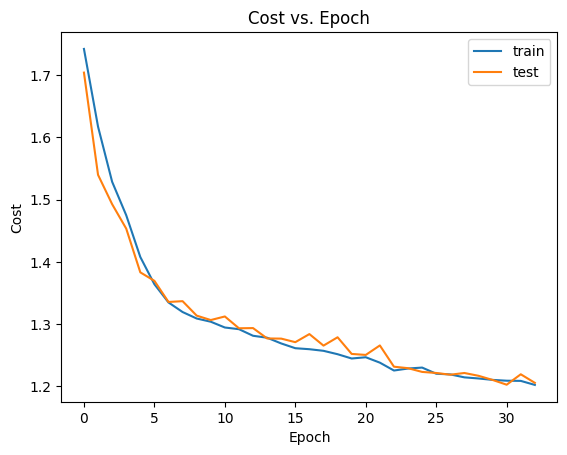

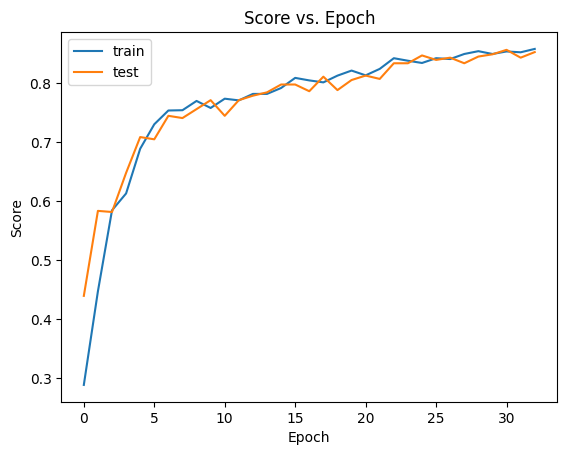

In [12]:
fit(train_set, trainloader, test_set, testloader, model, criterion, optimizer, device, early_stop, epoch)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [17]:
optimizer = optim.Adam(model.parameters(), lr=0.00001)

early_stop.reset_early_stop()
early_stop.early_stop_patience = 5
epoch = 30

Test: 100%|██████████| 17/17 [00:13<00:00,  1.28it/s]


Epoch 36: train_cost=1.1967, test_cost=1.1955, train_score=0.8610, test_score=0.8580


Test: 100%|██████████| 17/17 [00:12<00:00,  1.34it/s]


Epoch 37: train_cost=1.1965, test_cost=1.1954, train_score=0.8595, test_score=0.8561


Test: 100%|██████████| 17/17 [00:13<00:00,  1.28it/s]


Epoch 38: train_cost=1.1949, test_cost=1.1966, train_score=0.8581, test_score=0.8617
EarlyStop patience =  1. Best test_cost: 1.1954


Test: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 39: train_cost=1.1936, test_cost=1.1962, train_score=0.8657, test_score=0.8561
EarlyStop patience =  2. Best test_cost: 1.1954


Test: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 40: train_cost=1.1893, test_cost=1.1945, train_score=0.8695, test_score=0.8598


Test: 100%|██████████| 17/17 [00:13<00:00,  1.29it/s]


Epoch 41: train_cost=1.1946, test_cost=1.1950, train_score=0.8581, test_score=0.8617
EarlyStop patience =  1. Best test_cost: 1.1945


Test: 100%|██████████| 17/17 [00:13<00:00,  1.28it/s]


Epoch 42: train_cost=1.1921, test_cost=1.1944, train_score=0.8686, test_score=0.8617


Test: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 43: train_cost=1.1899, test_cost=1.1929, train_score=0.8686, test_score=0.8636


Test: 100%|██████████| 17/17 [00:13<00:00,  1.22it/s]


Epoch 44: train_cost=1.1935, test_cost=1.1950, train_score=0.8686, test_score=0.8598
EarlyStop patience =  1. Best test_cost: 1.1929


Test: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 45: train_cost=1.1873, test_cost=1.1955, train_score=0.8676, test_score=0.8580
EarlyStop patience =  2. Best test_cost: 1.1929


Test: 100%|██████████| 17/17 [00:12<00:00,  1.34it/s]


Epoch 46: train_cost=1.1939, test_cost=1.1933, train_score=0.8662, test_score=0.8636
EarlyStop patience =  3. Best test_cost: 1.1929


Test: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch 47: train_cost=1.1945, test_cost=1.1930, train_score=0.8648, test_score=0.8636
EarlyStop patience =  4. Best test_cost: 1.1929


Test: 100%|██████████| 17/17 [00:13<00:00,  1.27it/s]


Epoch 48: train_cost=1.1887, test_cost=1.1938, train_score=0.8710, test_score=0.8655
EarlyStop patience =  5. Best test_cost: 1.1929
Training early stopped. tidak ada peningkatan pada 5 epoch terakhir atau mencapai target score.
Early Stopping pada epoch: 47 | Best test_cost: 1.1929


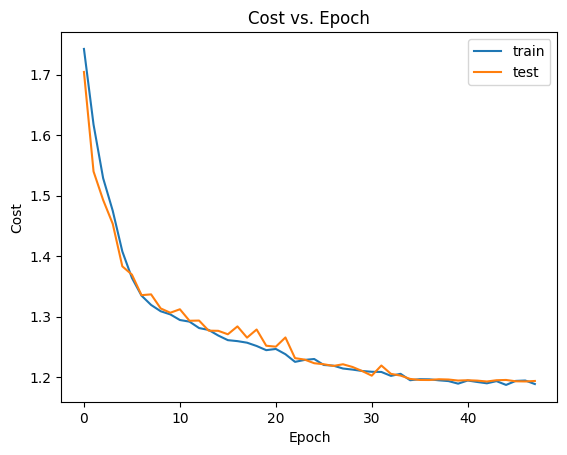

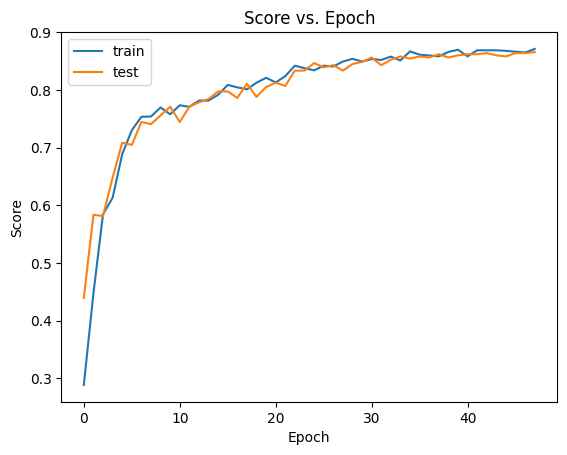

In [18]:
fit(train_set, trainloader, test_set, testloader, model, criterion, optimizer, device, early_stop, epoch)

In [48]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image


activation = {}
jumlah = 100

def get_activation(name):
    def hook(module, input, output):
        activation[name] = output.detach()
    return hook

model.feature[0][0].register_forward_hook(get_activation('conv'))
model.feature[0][3].register_forward_hook(get_activation('conv1'))
model.feature[2][0].register_forward_hook(get_activation('conv2'))
model.feature[2][3].register_forward_hook(get_activation('conv3'))
model.feature[4][0].register_forward_hook(get_activation('conv4'))
model.feature[4][3].register_forward_hook(get_activation('conv5'))


model.feature[0][2].register_forward_hook(get_activation('relu1'))
model.feature[0][5].register_forward_hook(get_activation('relu2'))
model.feature[2][2].register_forward_hook(get_activation('relu3'))
model.feature[2][5].register_forward_hook(get_activation('relu4'))
model.feature[4][2].register_forward_hook(get_activation('relu5'))
model.feature[4][5].register_forward_hook(get_activation('relu6'))


img = Image.open('/kaggle/input/rice-leafs-disease-dataset/RiceLeafsDisease/validation/brown_spot/brown_val (27).jpg')
rgb_image = img.convert('RGB')

transform = transforms.Compose([
    transforms.Resize(size=(230)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor()
])
img_tensor = transform(rgb_image)
img_tensor = img_tensor.unsqueeze(0)
img_tensor = img_tensor

output = model(img_tensor)

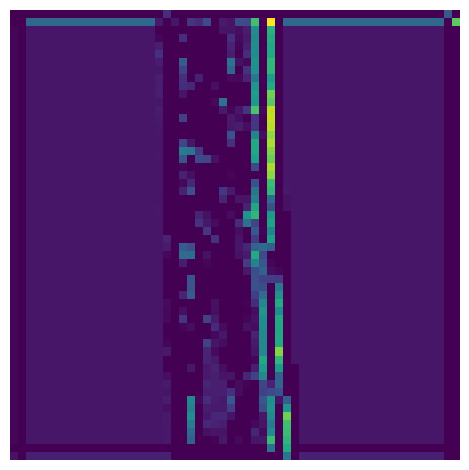

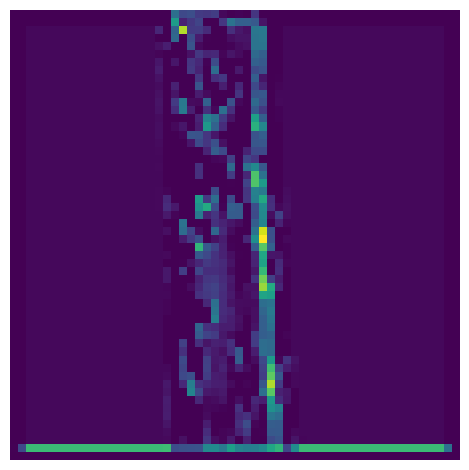

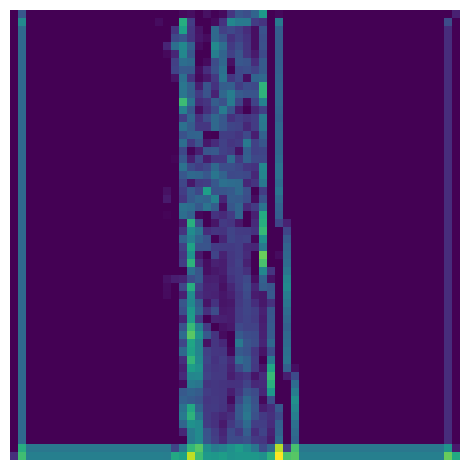

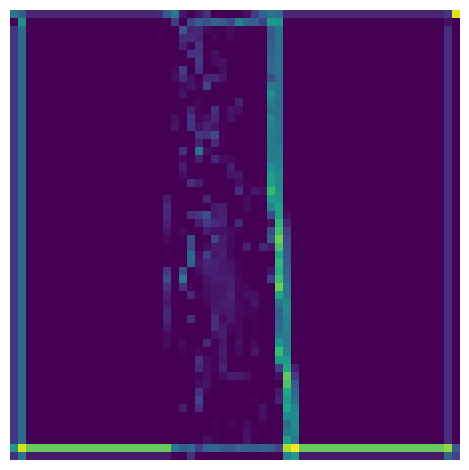

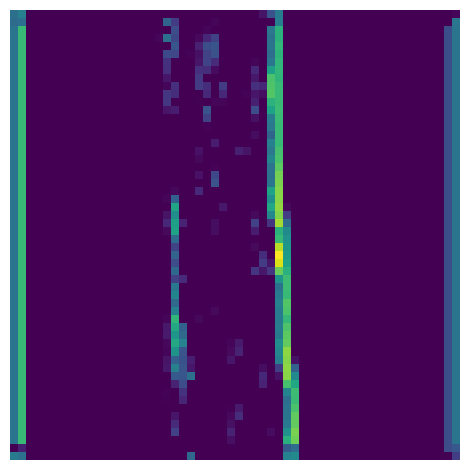

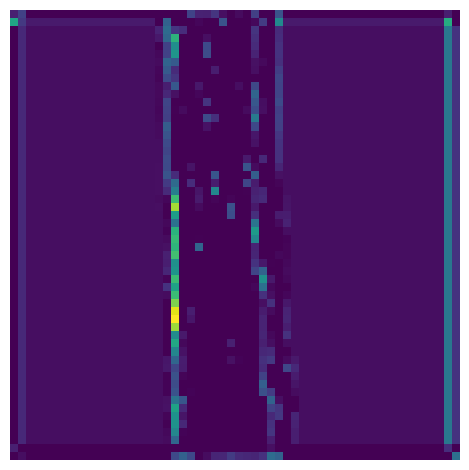

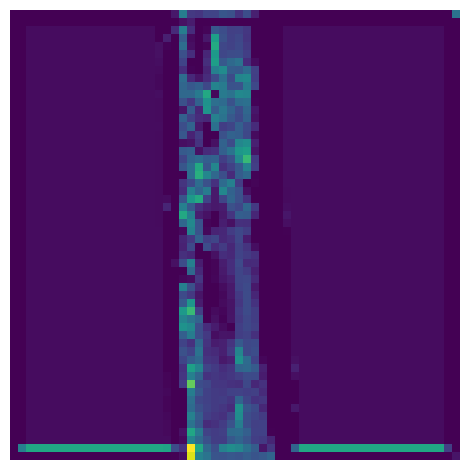

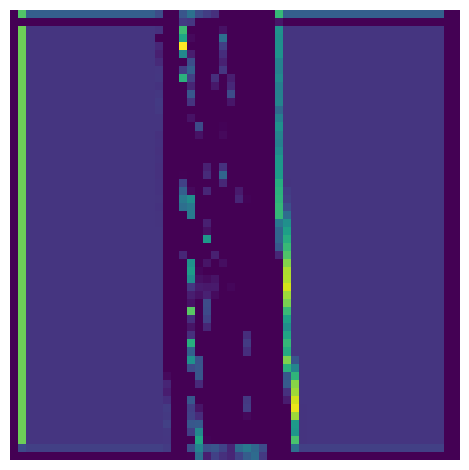

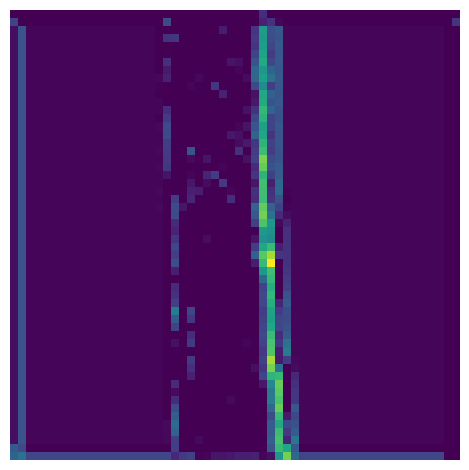

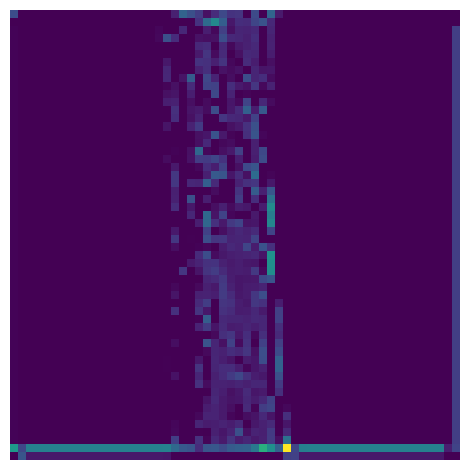

In [60]:
folder_path = 'custom_img003copy'
file = 'relu6'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)


subfolder_name = file

new_folder_path = os.path.join(folder_path, subfolder_name)

if not os.path.exists(new_folder_path):
    os.makedirs(new_folder_path)

for i in range(10):
    fig, ax = plt.subplots(1, 1)
    ax.imshow(activation[file][0, i].cpu().numpy())
    ax.axis('off')
    plt.tight_layout()
    
    fig.savefig(f'{new_folder_path}/{file}-{i}.png', dpi=300, transparent=True)

tensor([[[[1.0000, 1.0000, 0.8235, 0.8314, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.8275, 0.8000, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.8510, 0.7843, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.8784, 0.7765, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.9059, 0.7843, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.9216, 0.7882, 0.9961, 1.0000]],

         [[1.0000, 1.0000, 0.8784, 0.8745, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.8863, 0.8588, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.8902, 0.8275, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.9059, 0.8275, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.9255, 0.8471, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.9490, 0.8627, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 0.7176, 0.7059, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.7176, 0.6471, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.7451, 0.6000, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.7843, 0.5843, 0.9961, 1.0000],
          [1.0000, 1.0000, 0.8196, 0

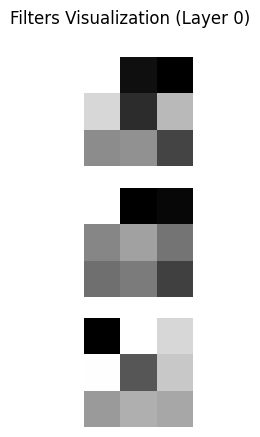

bias :tensor([0.2256, 0.2404, 0.2995])


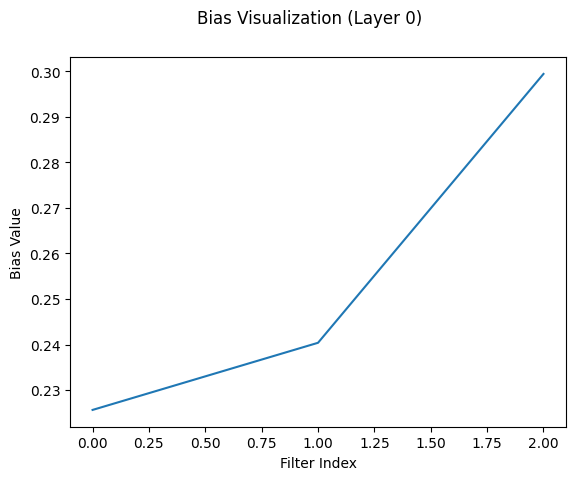

fitur :tensor([[[[ 0.2416,  0.5191,  0.5333,  0.4888,  0.4814,  0.4585],
          [-0.1911,  0.4378,  0.4844,  0.3519,  0.2997,  0.5705],
          [-0.1911,  0.4383,  0.4880,  0.3680,  0.2859,  0.5705],
          [-0.1911,  0.4348,  0.4834,  0.3881,  0.2797,  0.5705],
          [-0.1911,  0.4315,  0.4782,  0.4050,  0.2790,  0.5702],
          [-0.1818,  0.3636,  0.3999,  0.3785,  0.2401,  0.4257]],

         [[-0.1489, -0.2883, -0.2707, -0.2866, -0.2980, -0.0378],
          [-0.7294, -0.6948, -0.6316, -0.7040, -0.7509, -0.1935],
          [-0.7294, -0.7004, -0.6278, -0.6995, -0.7510, -0.1935],
          [-0.7294, -0.7067, -0.6257, -0.6944, -0.7575, -0.1935],
          [-0.7294, -0.7174, -0.6376, -0.6978, -0.7605, -0.1935],
          [-0.4588, -0.3578, -0.3039, -0.3428, -0.3964, -0.0024]],

         [[ 0.8978,  1.2449,  1.1712,  1.1532,  1.2117,  0.9664],
          [ 1.4588,  1.6257,  1.4396,  1.5325,  1.6661,  1.1659],
          [ 1.4588,  1.6383,  1.4200,  1.5233,  1.6552,  1.1654],

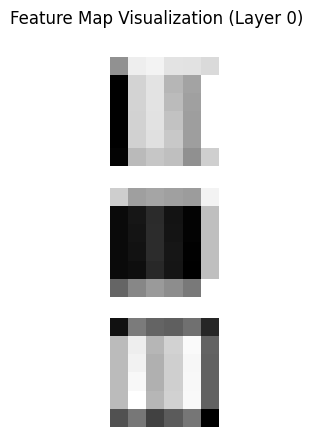

relu :tensor([[[[0.2416, 0.5191, 0.5333, 0.4888, 0.4814, 0.4585],
          [0.0000, 0.4378, 0.4844, 0.3519, 0.2997, 0.5705],
          [0.0000, 0.4383, 0.4880, 0.3680, 0.2859, 0.5705],
          [0.0000, 0.4348, 0.4834, 0.3881, 0.2797, 0.5705],
          [0.0000, 0.4315, 0.4782, 0.4050, 0.2790, 0.5702],
          [0.0000, 0.3636, 0.3999, 0.3785, 0.2401, 0.4257]],

         [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.8978, 1.2449, 1.1712, 1.1532, 1.2117, 0.9664],
          [1.4588, 1.6257, 1.4396, 1.5325, 1.6661, 1.1659],
          [1.4588, 1.6383, 1.4200, 1.5233, 1.6552, 1.1654],
          [1.4588, 1.6596, 1.4225, 1.5227, 1.6568, 1.1641],
          [1.4588, 1.6830, 1.4

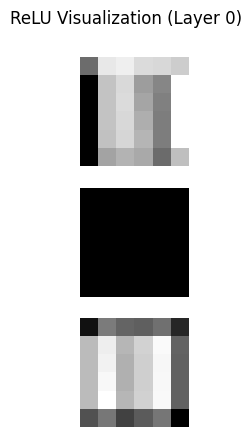

In [29]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

def visualize_filters(model, layer_idx):
    layer = model.feature[layer_idx][0]
    filters = layer.weight.data
    filters = filters - filters.min()
    filters = filters / filters.max()

    fig, axs = plt.subplots(filters.size(0))
    fig.suptitle('Filters Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        filter_img = filters[i].permute(1, 2, 0).cpu().numpy()
        ax.imshow(filter_img.squeeze(), cmap='gray')  
        ax.axis('off')
        print(f"filer :{filter_img}")

    plt.show()
    
def visualize_bias(model, layer_idx):
    layer = model.feature[layer_idx][0]
    bias = layer.bias.data

    fig, ax = plt.subplots()
    fig.suptitle('Bias Visualization (Layer {})'.format(layer_idx))

    ax.plot(bias.cpu().numpy())
    ax.set_xlabel('Filter Index')
    ax.set_ylabel('Bias Value')
    print(f"bias :{bias}")
    plt.show()
    
    

def visualize_feature_maps(model, layer_idx, input_image):
    activations = model.feature[0][layer_idx](input_image)
    activations = activations.detach()

    fig, axs = plt.subplots(activations.size(1))
    fig.suptitle('Feature Map Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        ax.imshow(activations[0, i, :, :].cpu(), cmap='gray')  
        ax.axis('off')
        print(f"fitur :{activations}")

    plt.show()

def visualize_relu(model, layer_idx, input_image):
    activations = model.feature[0][layer_idx](input_image)
    relu_activations = torch.relu(activations)
    relu_activations = relu_activations.detach()

    fig, axs = plt.subplots(relu_activations.size(1))
    fig.suptitle('ReLU Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        ax.imshow(relu_activations[0, i, :, :].cpu(), cmap='gray')  
        ax.axis('off')
        print(f"relu :{relu_activations}")

    plt.show()

output_size = 10  
model = CNNpenyakitPadi(output_size)

transform = transforms.Compose([
    transforms.Resize((6,6)),
    transforms.ToTensor()
])

image_path = '/kaggle/input/rice-leafs-disease-dataset/RiceLeafsDisease/validation/brown_spot/brown_val (28).jpg' 
input_image = Image.open(image_path)
input_image = transform(input_image).unsqueeze(0)


print(input_image)


visualize_filters(model, 0)

visualize_bias(model, 0)

visualize_feature_maps(model, 0, input_image)

visualize_relu(model, 0, input_image)